predict :  tf.Tensor([0.5282091], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.3386248], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.03274066], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.12609325], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.00876343], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.506636], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.4118138], shape=(1,), dtype=float32)
predict :  tf.Tensor([1.2130697], shape=(1,), dtype=float32)
predict :  tf.Tensor([1.1546606], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.7750998], shape=(1,), dtype=float32)
predict :  tf.Tensor([1.0113109], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.6536826], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.92384523], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.21282162], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.95801383], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.7413354], shape=(1,), dtype=float32)
predict :  tf.

predict :  tf.Tensor([0.05849141], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.16214013], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.11255062], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.15731649], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.12627257], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.29275188], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.11994352], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.66127914], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.01972432], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.03505872], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.02256439], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.0958512], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.08996127], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.16021195], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.34396592], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.07456257], shape=(1,), dtype=float32)


predict :  tf.Tensor([-0.03525979], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.09535589], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.0676404], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.03694126], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.13590889], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.01986042], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.17458324], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.02607833], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.0400962], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.03934713], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.35193303], shape=(1,), dtype=float32)
predict :  tf.Tensor([0.17090008], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.2029198], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.10099065], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.10608229], shape=(1,), dtype=float32)
predict :  tf.Tensor([-0.17772835], shape=(1,), dtype=float32)


TclError: invalid command name ".!canvas"

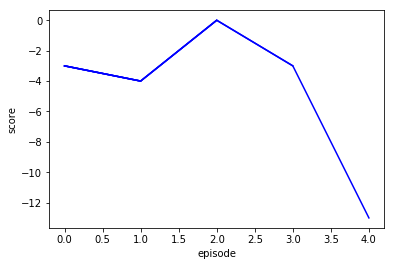

In [2]:
# %load train.py
import copy
import pylab
import random
import numpy as np
from environment import Env
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


# 딥살사 인공신경망
class DeepSARSA(tf.keras.Model):
    def __init__(self, action_size):
        super(DeepSARSA, self).__init__()
        self.fc1 = Dense(30, activation='relu')
        self.fc2 = Dense(30, activation='relu')
        self.fc_out = Dense(action_size)

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q


# 그리드월드 예제에서의 딥살사 에이전트
class DeepSARSAgent:
    def __init__(self, state_size, action_size):
        # 상태의 크기와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size
        
        # 딥살사 하이퍼 파라메터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.  
        self.epsilon_decay = .9999
        self.epsilon_min = 0.01
        self.model = DeepSARSA(self.action_size)
        self.optimizer = Adam(lr=self.learning_rate)

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_values = self.model(state)
            return np.argmax(q_values[0])

    # <s, a, r, s', a'>의 샘플로부터 모델 업데이트
    def train_model(self, state, action, reward, next_state, next_action, done):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # 학습 파라메터
        model_params = self.model.trainable_variables
        with tf.GradientTape() as tape:
            tape.watch(model_params)
            predict = self.model(state)[0]
            one_hot_action = tf.one_hot([action], self.action_size)
            predict = tf.reduce_sum(one_hot_action * predict, axis=1)
            
            # done = True 일 경우 에피소드가 끝나서 다음 상태가 없음
            next_q = self.model(next_state)[0][next_action]
            target = reward + (1 - done) * self.discount_factor * next_q

            # MSE 오류 함수 계산
            loss = tf.reduce_mean(tf.square(target - predict))
        
        # 오류함수를 줄이는 방향으로 모델 업데이트
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))


if __name__ == "__main__":
    # 환경과 에이전트 생성
    env = Env(render_speed=0.01)
    state_size = 15
    action_space = [0, 1, 2, 3, 4]
    action_size = len(action_space)
    agent = DeepSARSAgent(state_size, action_size)
    
    scores, episodes = [], []

    EPISODES = 1000
    for e in range(EPISODES):
        done = False
        score = 0
        # env 초기화
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            # 현재 상태에 대한 행동 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행 후 샘플 수집
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            next_action = agent.get_action(next_state) # 타임스텝을 진행하지는 않음

            # 샘플로 모델 학습
            agent.train_model(state, action, reward, next_state, 
                                next_action, done)
            score += reward
            state = next_state

            if done:
                # 에피소드마다 학습 결과 출력
                print("episode: {:3d} | score: {:3d} | epsilon: {:.3f}".format(
                      e, score, agent.epsilon))

                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.xlabel("episode")
                pylab.ylabel("score")
                pylab.savefig("./save_graph/graph.png")


        # 100 에피소드마다 모델 저장
        if e % 100 == 0:
            agent.model.save_weights('save_model/model', save_format='tf')

In [ ]:
# %load test.py
import random
import numpy as np
from environment import Env
import tensorflow as tf
from tensorflow.keras.layers import Dense


# 딥살사 인공신경망
class DeepSARSA(tf.keras.Model):
    def __init__(self, action_size):
        super(DeepSARSA, self).__init__()
        self.fc1 = Dense(30, activation='relu')
        self.fc2 = Dense(30, activation='relu')
        self.fc_out = Dense(action_size)

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q


# 그리드월드 예제에서의 딥살사 에이전트
class DeepSARSAgent:
    def __init__(self, state_size, action_size):
        # 상태의 크기와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        self.epsilon = 0.01
        self.model = DeepSARSA(self.action_size)
        self.model.load_weights('save_model/trained/model')

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_values = self.model(state)
            return np.argmax(q_values[0])


if __name__ == "__main__":
    # 환경과 에이전트 생성
    env = Env(render_speed=0.05)
    state_size = 15
    action_space = [0, 1, 2, 3, 4]
    action_size = len(action_space)
    agent = DeepSARSAgent(state_size, action_size)

    scores, episodes = [], []

    EPISODES = 10
    for e in range(EPISODES):
        score = 0
        done = False
        # env 초기화
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            # 현재 상태에 대한 행동 선택
            action = agent.get_action(state)

            # 선택한 행동으로 환경에서 한 타임스텝 진행 후 샘플 수집
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            state = next_state
            score += reward

            if done:
                # 에피소드마다 학습 결과 출력
                print("episode: {:3d} | score: {:3d}".format(e, score))